In [2]:
import pandas as pd
import numpy as np
import random
import scipy
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

**Задание **

Провести аналогичные исследования но для чека покупок клиентов (колонки `revenue`)  
в интернет магазине есть 2-ва типа продуктов:
* 100 руб.
* 250 руб.

ну и конечно клиент может ничего не купить  
провести исследование изменился ли средний чек

In [3]:
df = pd.read_csv('ab_datas.csv')

df.head()

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,250


Revenue по всем посетителям

In [9]:
mean_revenue=df['revenue'].mean()
print("Revenue:", mean_revenue)

Revenue: 101.9677191504968


Посмотрим на различия revenue в двух группах

In [11]:
df_grp = df.groupby('group')['revenue']
df_grp.describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,147202.0,87.431896,102.424926,0.0,0.0,0.0,250.0,250.0
treatment,147276.0,116.496238,102.732069,0.0,0.0,100.0,250.0,250.0


Заметно что mean достаточно разный, но нам необходимо проверить, статистически ли важно это различие?

Вообще, забегая вперед, видно что стандартное отклонение одинаковое, а значит, разница средних все таки будет статистически важна, но нам необходимо это доказать на цифрах с помощью стат теста.

In [15]:
#объем тестовой группы
n_rows_treat = len(df[df['group'] == 'treatment'])

#объем контрольной группы
n_rows_contr = n_rows-n_rows_treat

print("Соотношение размеров тестовой и контрольной групп: {}".format(n_rows_treat/n_rows_contr))

Соотношение размеров тестовой и контрольной групп: 1.0005027105609978


<a id='si1'></a>
#### Формулировка рабочей гипотезы

Рабочая гипотеза в нашем случае может быть сформулирована, например, так: "Revenue пользователей со старым дизайном не меньше, чем с новым"

<a id='si2'></a>
#### Формальное описание нулевой и альтернативной гипотез

$H_{0}$ : $\theta_{new}$ <= $\theta_{old}$ 

$H_{1}$ : $\theta_{new}$ > $\theta_{old}$ 

Посмотрим на распределения средних в bootstrap:

In [34]:
b = df.loc[df['group']=='treatment', 'revenue'].values
a = df.loc[df['group']=='control', 'revenue'].values

In [35]:
from sklearn.utils import resample

a_means = []
b_means = []

for i in range(10000):
    a_boot = resample(a, replace=True, n_samples=len(a))
    b_boot = resample(b, replace=True, n_samples=len(b))
    
    a_means.append(a_boot.mean())
    b_means.append(b_boot.mean())
    
a_means = np.array(a_means)
b_means = np.array(b_means)

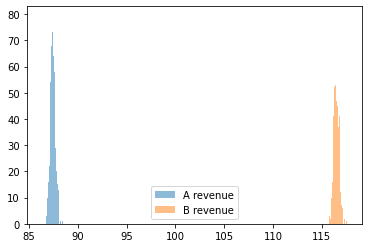

In [33]:
plt.hist(a_means, label='A revenue', alpha=0.5, bins=500)
plt.hist(b_means, label='B revenue', alpha=0.5, bins=500)

plt.legend()
plt.show()

In [36]:
# доверительный интервал
np.percentile(a_means, 2.5), np.percentile(a_means, 97.5)

(86.91284765152648, 87.95498702463281)

In [37]:
# сделаем оценку на p_value
dff = a_means - b_means

len(dff[dff>=0])/len(dff)

0.0

Как видим, p_value стремится к нулю, а значит принимаем альтернативную гипотезу.

<a id='si4'></a>
#### Проведение вычислений. $Z$-критерий.

In [30]:
tstat, pvalue = sm.stats.ztest(b, a, alternative='larger')

In [32]:
tstat, pvalue

(76.87762011494505, 0.0)

Точно так же, p value = 0, принимаем альтернативную гипотезу

#### Проведение вычислений. $T$-test.

In [39]:
t_score, p_value, _ = statsmodels.stats.weightstats.ttest_ind(df.query("group == 'treatment'")['revenue'],
                                                              df.query("group == 'control'")['revenue'],
                                                              alternative="larger",
                                                              usevar='unequal')

In [40]:
print("T-статистика={},  p_value={}".format(t_score, p_value))

T-статистика=76.87767795975593,  p_value=0.0


#### Проведение вычислений. $Mann–Whitney$-test.

In [41]:
w_score, p_value = scipy.stats.mannwhitneyu(df.query("group == 'treatment'")['revenue'], 
                         df.query("group == 'control'")['revenue'],
                         alternative="greater")

In [42]:
print("W-статистика={},  p_value={}".format(w_score, p_value))

W-статистика=12643398633.5,  p_value=0.0


### Домашнее задание

#### 1. Если мы рассчитали 95% доверительный интервал для среднего значения, то какие из следующих утверждений являются верными?

Выберите несколько вариантов и попытайтесь объяснить свой выбор:

- ~~1) Если многократно повторять эксперимент, то 95 % выборочных средних значений будут принадлежать рассчитанному нами доверительному интервалу.~~ *тут было сложнее всего, мне кажется, что доверительный интервал рассчитывает именно вероятность попадания истинного среднего в него, а не среднего других случайных выборок*
- <u><b>2) Мы можем быть на 95% уверены, что среднее значение в генеральной совокупности принадлежит рассчитанному доверительному интервалу.</b></u>
- <u><b>3) Если многократно повторять эксперимент, для каждой выборки рассчитывать свой доверительный интервал, то в 95 % случаев истинное среднее будет находиться внутри доверительного интервала.</b></u>
- ~~4) Среднее значение в генеральной совокупности точно превышает нижнюю границу 95% доверительного интервала.~~
- ~~5) Среднее значение в генеральной совокупности точно принадлежит рассчитанному доверительному интервалу.~~



#### 2. Если мы увеличиваем объем выборки в два раза (при условии, что показатель стандартного отклонения остается неизменным), то 95% доверительный интервал

Выберите один вариант из списка

- <u><b>1) стал более узким</b></u>
- 2) ~~возможны оба варианта~~
- 3) ~~стал более широким~~

*По формуле вычисления доверительного интервала
$CI = \bar{x} \pm z \frac{s}{\sqrt{n}}$
, n (объем выборки) находится в знаменателе, а значит, чем больше n, тем меньше (уже) будет интервал*

#### 3. В центре 95% доверительного интервала, рассчитанного по выборочным значениям, находится:

Выберите один вариант из списка

- ~~1) Значение стандартной ошибки среднего~~
- <u><b>2) Выборочное среднее значение</b></u>
- ~~3) Среднее значение генеральной совокупности~~

*В этом ответе я не уверен, но кажется что среднее значение генеральной совокупности не обязательно будет являться центром доверительного интервала, ведь мы всего лишь на 95% уверены, что среднее значение в целом находится в этом интервале, а значит, в теории, истинное среднее значение генеральной совокупности может вовсе находиться за пределом интервала.*

#### 4. Часто на практике нулевая гипотеза отклоняется, и различия считаются статистически достоверными, если p < 0,05. Однако часто в статистике используется более жесткий критерий достоверности различий, например, при условии, что p < 0,01. Значение p-уровня значимости, которое выбирается, в качестве порога обозначается буквой α (альфа). Например, если исследователь решил, что α = 0,05, то и нулевая гипотеза будет отклоняться при условии, что p < 0,05. 

#### Если в определенной ситуации весьма рискованно отклонить нулевую гипотезу, когда она на самом деле верна, то лучше использовать показатель α равный 

Выберите один вариант из списка

- ~~1) 0,1~~
- <u><b>2) 0,001</b></u>
- ~~3) 0,05~~
- ~~4) 0,5~~

*Чем больше уровень значимости, тем меньше шансов на ошибку первого рода. То есть при уровне значимости 99.99%, порог p-value = 0.001, а значит с 99.99% вероятностью мы не совершим ошибку первого рода.*

#### 5. Данные некоторого исследования сообщают нам, что средний рост детей в 14 лет составляет 166 сантиметров. Однако это лишь выборочная оценка, и исследователи рассчитали 95% доверительный интервал, который составил [160, 172]. Укажите верные утверждения:

Выберите несколько вариантов и попытайтесь объяснить свой выбор:

- <u><b>1) У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 173</b></u>
- ~~2) Вероятность того, что истинное среднее значение больше 172, составляет 0,01~~ *0.025
- <u><b>3) У нас достаточно оснований отклонить нулевую гипотезу, что среднее в генеральной совокупности равняется 158.</b></u>
- ~~4) Доверительный интервал не может иметь такие границы, т. к. выборочное стандартное отклонение равняется 10, следовательно доверительный интервал должен быть значительно шире.~~

*1 и 3 с уровнем значимости в 95% мы можем отклонить нулевые гипотезы. 4-е утверждение я если честно не понял, я не увидел информации о том, какой у нас объем выборки, поэтому не уверен как это посчитать*

#### 6. Предположим, нулевой гипотезой вашего исследования являлось предположение, что конверсия в генеральной совокупности равняется 0.4. Вы получили p = 0,12 и не смогли отклонить нулевую гипотезу. Однако позже выяснилось, что конверсия в генеральной совокупности действиетльно равна 0.4. Как можно оценить результаты?


Какой вариант корректный по вашему мнению и почему?
- <u><b>1) Вы не совершали ни ошибку первого рода, ни ошибку второго рода.</b></u>
- ~~2) Вы совершили ошибку первого рода~~
- ~~3) Вы совершили ошибку второго рода~~

*Получив p-value 0.12 и приняв нулевую гипотезу мы позже убедились что нулевая гипотеза верна и конверсия генеральной совокупности действительно равна 0.4. Мы не допустили ошибку.*